# analysis.ipynb
This notebook contains the code for cleaning the 311 complaint data and merging it with data from the US census

# 0. Imports

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R 

library(tidycensus)
library(tidyverse)
library(sf)
library(GGally)
library(car)

sf::sf_use_s2(FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Spherical geometry (s2) switched off


In [4]:
from dotenv import load_dotenv
load_dotenv()
import os

api_key = os.getenv("CENSUS_API_KEY")
%R -i api_key

In [5]:
%%R

census_api_key(api_key)

To install your API key for use in future sessions, run this function with `install = TRUE`.


# 1. Read in data

In [6]:
%%R

df <-read_csv("311_illegal_parking_041424.csv")

Rows: 2451728 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (24): agency, agency_name, complaint_type, descriptor, location_type, i...
dbl   (7): unique_key, incident_zip, bbl, x_coordinate_state_plane, y_coordi...
dttm  (4): created_date, resolution_action_updated_date, closed_date, due_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# 2. Clean data

In [7]:
%%R

df %>% 
    pull(latitude) %>%
    is.na() %>%
    sum()


[1] 22075


A little less than a percent of the complaints don't have latitudes and longitudes but do have street addresses. This can be handled with Geocodio but for now I'm just dropping them as, assuming the missingness is random, this shouldn't affect my conclusions. 

In [8]:
%%R
df <- df %>%
    filter(is.na(latitude)==FALSE) %>%
    st_as_sf(coords = c("longitude","latitude"))  %>% 
    st_set_crs(4326)

In [9]:
%%R
D_census <- get_acs(geography = "tract",
                    state = "NY", 
                    county = c(
                        "Kings",
                        "Bronx",
                        "New York",
                        "Richmond",
                        "Queens"),
                    variables=c(
                     med_inc="B19013_001",
                     white = "B02001_002", 
                     black = "B02001_003",
                     asian = "B02001_005",
                     hispanic = "B03002_012",
                     poverty = "B17001_002"),
                    summary_var = "B01003_001",
                    geometry = TRUE) %>%
    select(-moe, -summary_moe) %>%
    pivot_wider(names_from = "variable", values_from = "estimate") %>%
    st_as_sf %>% 
    mutate(black_perc = black/summary_est,
          asian_perc = asian/summary_est,
          hispanic_perc = hispanic/summary_est,
         pov_perc = poverty/summary_est) %>% 
    st_set_crs(4326)

  |======================================================================| 100%


Getting data from the 2018-2022 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '047' for 'Kings County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '061' for 'New York County'
Using FIPS code '085' for 'Richmond County'
Using FIPS code '081' for 'Queens County'
In addition: Warning message:
st_crs<- : replacing crs does not reproject data; use st_transform for that 


In [10]:
%%R
df <- df %>%
    st_join(D_census) %>%
    data.frame

although coordinates are longitude/latitude, st_intersects assumes that they
are planar


In [11]:
%%R
df <- df %>%
    left_join(D_census %>%
                data.frame %>%
                select(NAME,geometry), by = "NAME") %>%
    st_as_sf

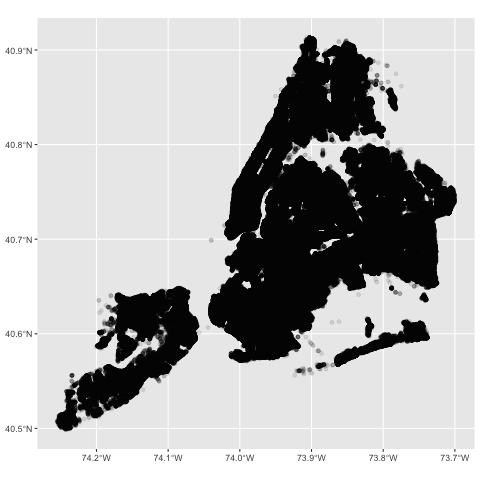

In [12]:
%%R

df %>%
    st_as_sf %>%
    ggplot()+geom_sf(alpha = 1/10)

Well well well, that's New York!

In [13]:
%%R

df_tract <- df %>%
    data.frame %>%
    group_by(NAME) %>%
    summarise(n_complaints= n(),
                geometry=geometry.y[1],
                blk_perc = black_perc[1],
                asn_perc = asian_perc[1],
                hisp_perc = hispanic_perc[1],
                pov_perc = pov_perc[1],
                med_inc = med_inc[1],
                summary_est=summary_est[1]) %>%
    st_as_sf %>%
    na.omit

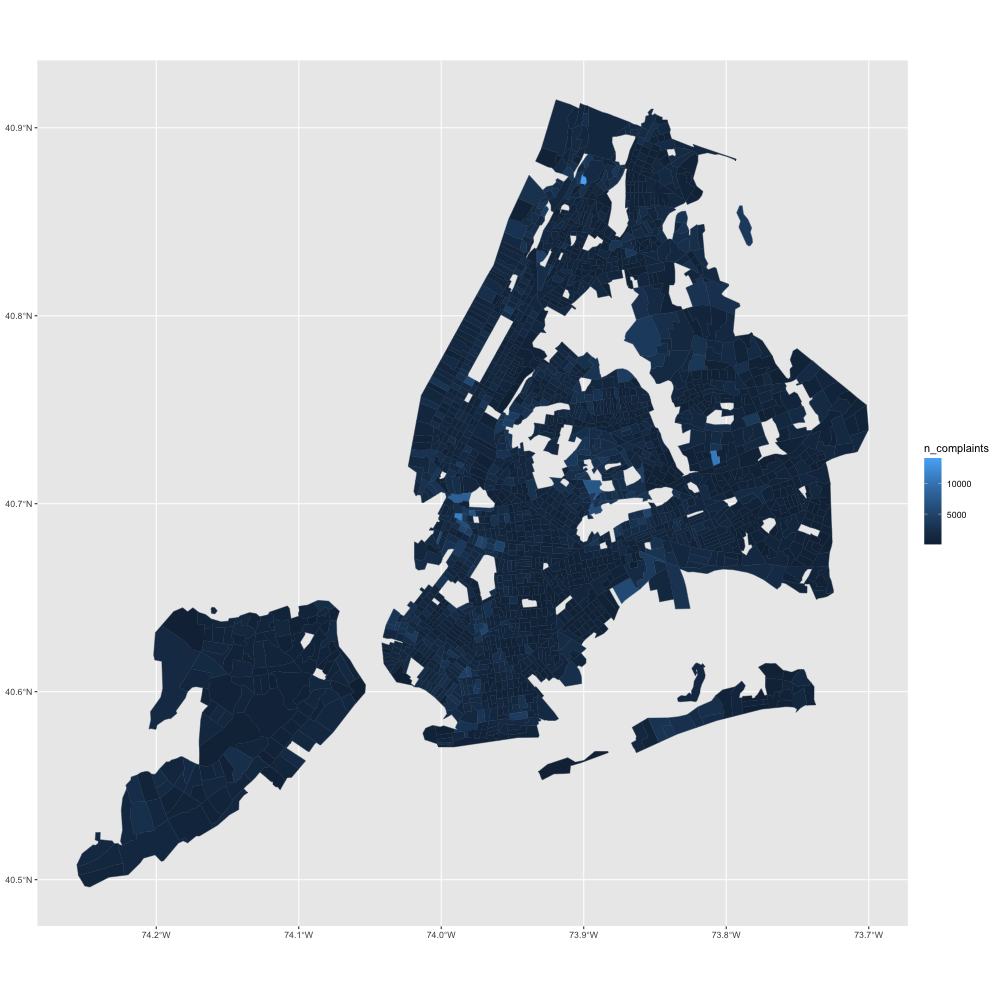

In [14]:
%%R -w 1000 -h 1000

df_tract %>%
    ggplot(aes(color = n_complaints, fill = n_complaints))+
        geom_sf()

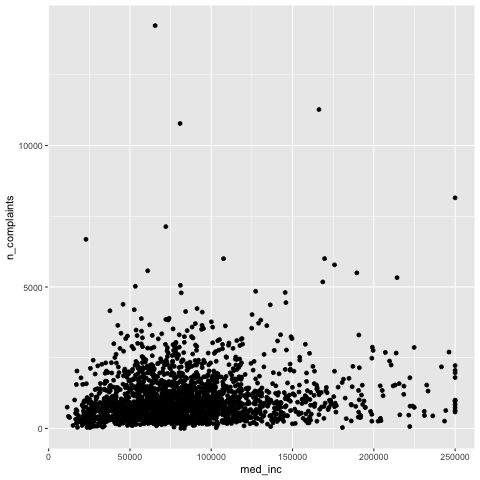

In [15]:
%%R

df_tract %>%
    ggplot() +
        aes(x=med_inc, y=n_complaints) +
        geom_point()

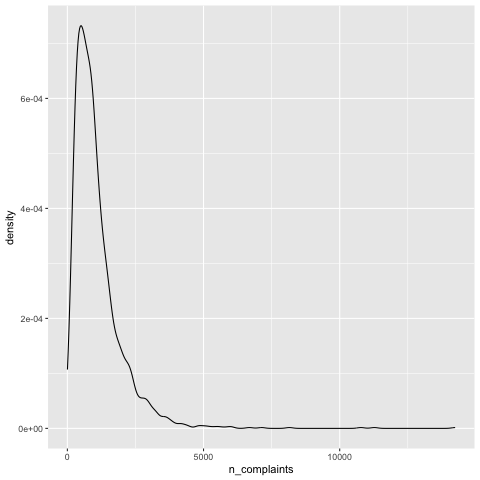

In [16]:
%%R

df_tract %>%
    ggplot() +
        aes(x=n_complaints) +
        geom_density()

In [17]:
# %%R

# df %>%
#     mutate(created_date = as.Date(created_date)) %>%
#     group_by(created_date) %>%
#     summarise(count = n()) %>%
#     arrange(created_date) %>%
#     ggplot(aes(x = created_date, y = count)) +
#         geom_line()